# Data Forecasting

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [5]:
# Load processed Data
data = pd.read_csv('../data/processed/vgsales_processed.csv')

To begin with, we'll do some correlation analysis, to determine which are the most important features when trying to get sales.

First correlation will be total sales and and possible features:

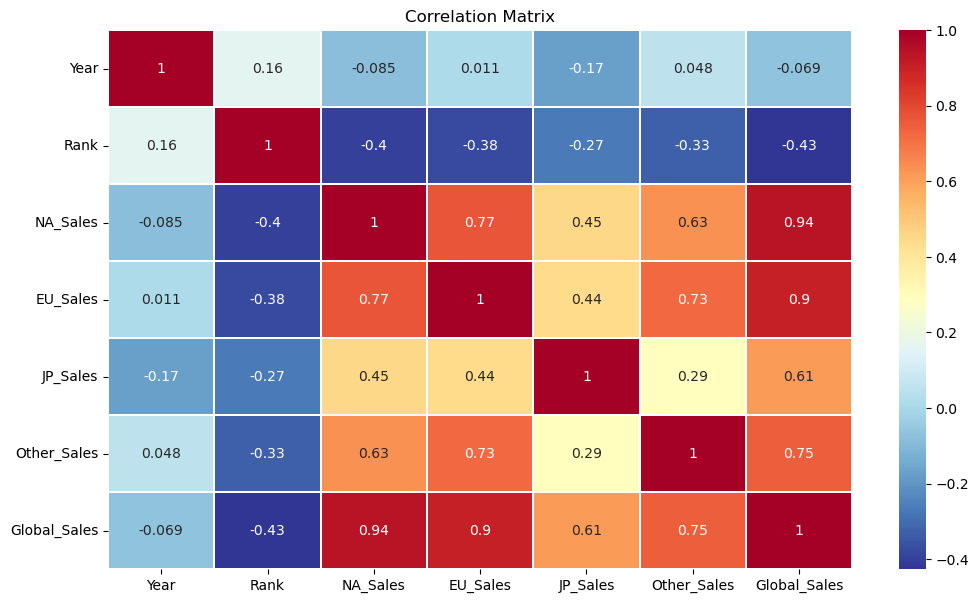

In [7]:
columns = ['Year', 'Rank', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']

# We create the correlation matrix
corr_ = data[columns].corr()

# Create the heatmap
plt.figure(figsize=(12, 7))
sns.heatmap(corr_, annot=True, linewidths=.2, cmap='RdYlBu_r')

plt.title('Correlation Matrix')
plt.show()

With this chart, we can clearly see that NA_Sales and EU_Sales have the most influence on global sales, so companies should focus on Europe and North America when trying to maximize sales. Other variables doesn't affect that much.

Lets' now try to correlate total sales and Platforms, to determine if ther are best selling platforms:

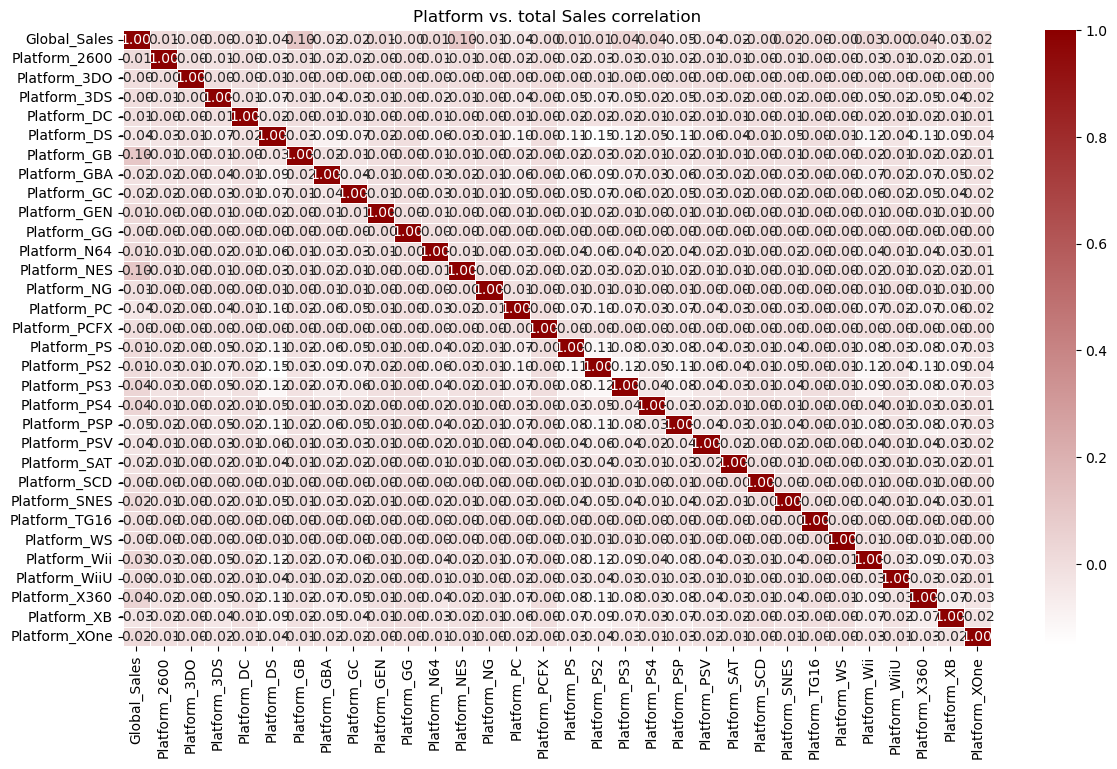

In [9]:
# First, we create dummy variables for 'Platform'
platform_dummies = pd.get_dummies(data['Platform'], prefix='Platform')

# Select the relevant column for analysis
data_with_dummies = pd.concat([data, platform_dummies], axis=1)
corr_data = data_with_dummies[['Global_Sales'] + list(platform_dummies.columns)]

# We create the correlation matrix
corr_ = corr_data.corr()

cmap = mcolors.LinearSegmentedColormap.from_list('white_to_red', ['white', 'darkred'])

# Create the heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(corr_, annot=True, linewidths=.5, cmap=cmap, fmt='.2f')

plt.title('Platform vs. total Sales correlation')
plt.show()

Even if it seems like GB (Game Boy) and NES are the most important when determine sales, (0.10 in both cases) this correlation isn't that important to determine a relevant correlation, so it looks like Platform isn't the most important factor for predicting sales.

Let's repeat the analysis with the genre of the videogame:

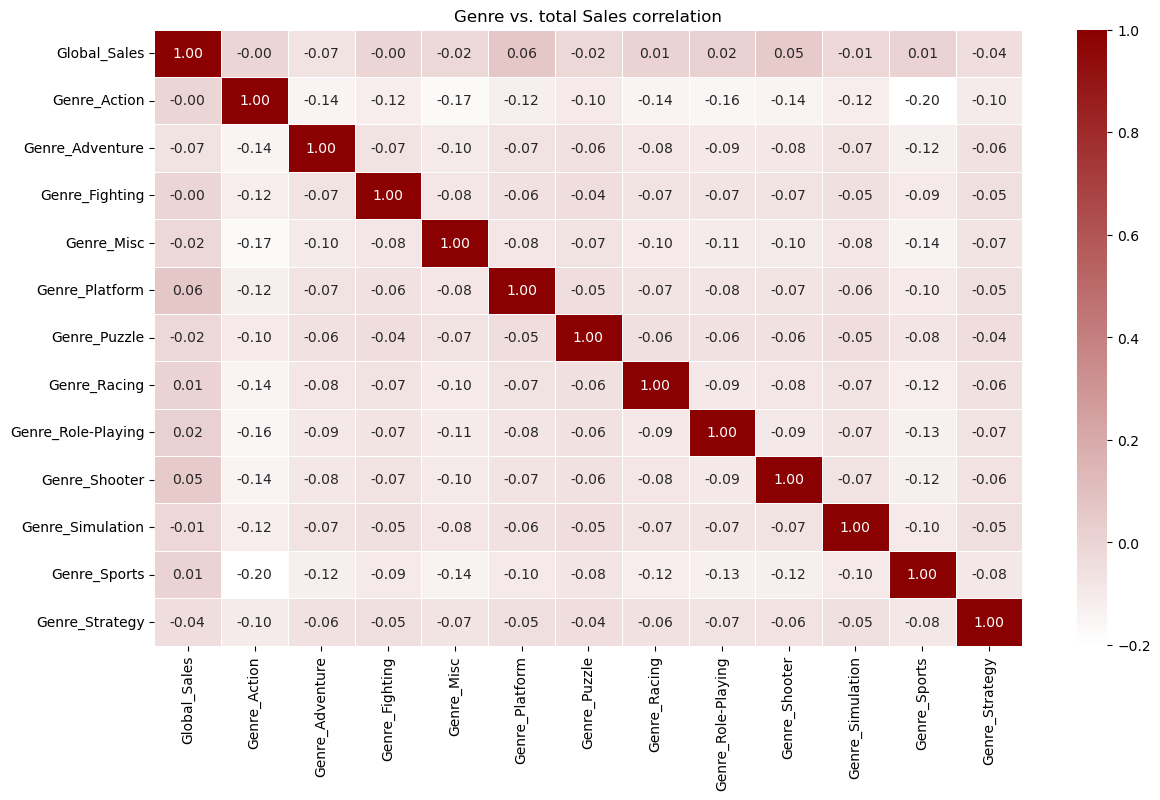

In [11]:
# First, we create dummy variables for 'Genre'
platform_dummies = pd.get_dummies(data['Genre'], prefix='Genre')

# Select the relevant column for analysis
data_with_dummies = pd.concat([data, platform_dummies], axis=1)
# Seleccionar las columnas relevantes para la correlación
corr_data = data_with_dummies[['Global_Sales'] + list(platform_dummies.columns)]

# We create the correlation matrix
corr_ = corr_data.corr()
cmap = mcolors.LinearSegmentedColormap.from_list('white_to_red', ['white', 'darkred'])

# Create the heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(corr_, annot=True, linewidths=.5, cmap=cmap, fmt='.2f')

plt.title('Genre vs. total Sales correlation')
plt.show()

As it happened with previous correlation analysis, we don't see any genre that has a clear correlation with sales, not positive nor negative correlation.

With this analysis done, let's do the correlation between sales and the top publishers:

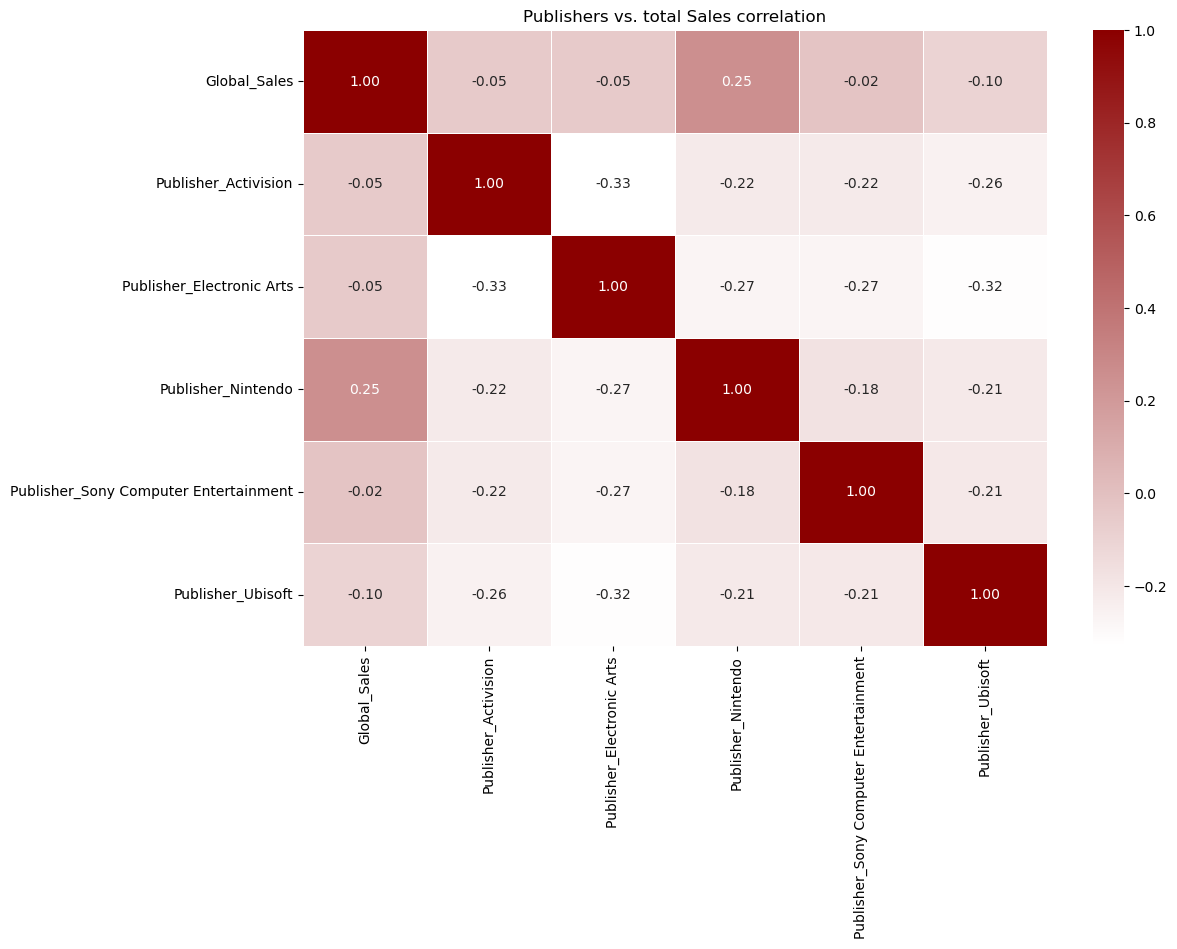

In [13]:
top_publishers = data.groupby('Publisher')['Global_Sales'].sum().nlargest(5).index

# Filter the TOP 5 publishers
filtered_data = data[data['Publisher'].isin(top_publishers)]

# We create dummy variables for 'Publishers'
publisher_dummies = pd.get_dummies(filtered_data['Publisher'], prefix='Publisher')

# Select the relevant column for analysis
filtered_data_with_dummies = pd.concat([filtered_data[['Global_Sales']], publisher_dummies], axis=1)

# We create the correlation matrix
corr_ = filtered_data_with_dummies.corr()
cmap = mcolors.LinearSegmentedColormap.from_list('white_to_red', ['white', 'darkred'])

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_, annot=True, linewidths=.5, cmap=cmap, fmt='.2f')

plt.title('Publishers vs. total Sales correlation')
plt.show()

This time we can see how there's a relevant correlation between the Nintendo Publisher and total Sales, but not for the Others. This is a positive correlation, that means that Nintendo games are more likely to get more sales.

## Forecasting

Now let's do some forecasting on future sales. We'll train a model using RandomForestRegressor, and use the TOP 5 values for each possible factor that has an influence on sales: 'Platform', 'Genre' and 'Publisher'. We d not take into account the sales per region, because it is so obvious that there's a correlation, given that the sum of the different regions are exactly the  total sales, so that would cause a perfect correlation, that doesn't make sense when analysing (of course the sum of sales equals total sales, but this is not relevant information!).

Without further due, let's start the forecasting using Machine Learning. We'll be commenting every step:

In [15]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

As the computation requirements are so high for being run on a computer, we'll be just using the TOP 5 values of every variable:

In [17]:
# TOP 5 values per variable
top_platforms = data.groupby('Platform')['Global_Sales'].sum().nlargest(5).index
top_genres = data.groupby('Genre')['Global_Sales'].sum().nlargest(5).index
top_publishers = data.groupby('Publisher')['Global_Sales'].sum().nlargest(5).index

filtered_data = data[data['Platform'].isin(top_platforms) & 
                     data['Genre'].isin(top_genres) &
                     data['Publisher'].isin(top_publishers)]

Now we define what will be the features and the target that we want to explain through the those features. We call them 'independent variables (X)' and 'dependent variable (Y)':

In [19]:
X = filtered_data[['Platform', 'Genre', 'Publisher']]
y = filtered_data[['Global_Sales']]

Now, we create the dummy variables in order to continue with the forecasting properly.

This step is mandatory when doing this proces, because lineal Machine Learning algorithms and pipelines require this type of variables for implementing categorical data:

In [21]:
# Create the Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['Platform', 'Genre', 'Publisher'])
    ]
)

As we said before, we'll be using a random forest regressor model for this exercice. This model has some benefits that are specially interesting for our purpose: first, it can detect not just linear relationships, but non-linear relationships too. Apart from that, Random Forest reduces the risk of overfitting. For those reasons, this is the perfect process for the project we're doing here:

In [23]:
# We create the model. We'll be using a n_estimator of 100, given that we used just the top features, 
# and a random state of 32 (no matter what we have chosen)
model = RandomForestRegressor(n_estimators=100, random_state=32)

Now we will be creating the pipeline and adjusting the model into it in order to make predictions:

In [25]:
# We create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', model)
])

In [26]:
# Then, we adjust the model with filtered data
pipeline.fit(X, y.values.ravel())

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Platform', 'Genre',
                                                   'Publisher'])])),
                ('regressor', RandomForestRegressor(random_state=32))])

Now that we have fit the data, we'll be doing and showing the predictions. First, let's see how combination of features will affect sales in the future. More specifically, jow many millions of sales can we expect when two variables are given on features.

In [28]:
# We create a DataFrame  with all possible combinations of features
combinations = pd.MultiIndex.from_product([top_platforms, top_genres, top_publishers],
                                         names=['Platform', 'Genre', 'Publisher']).to_frame(index=False)

In [29]:
# We make predictions for all feature combinations
predictions = pipeline.predict(combinations)

combinations['Global_Sales'] = predictions

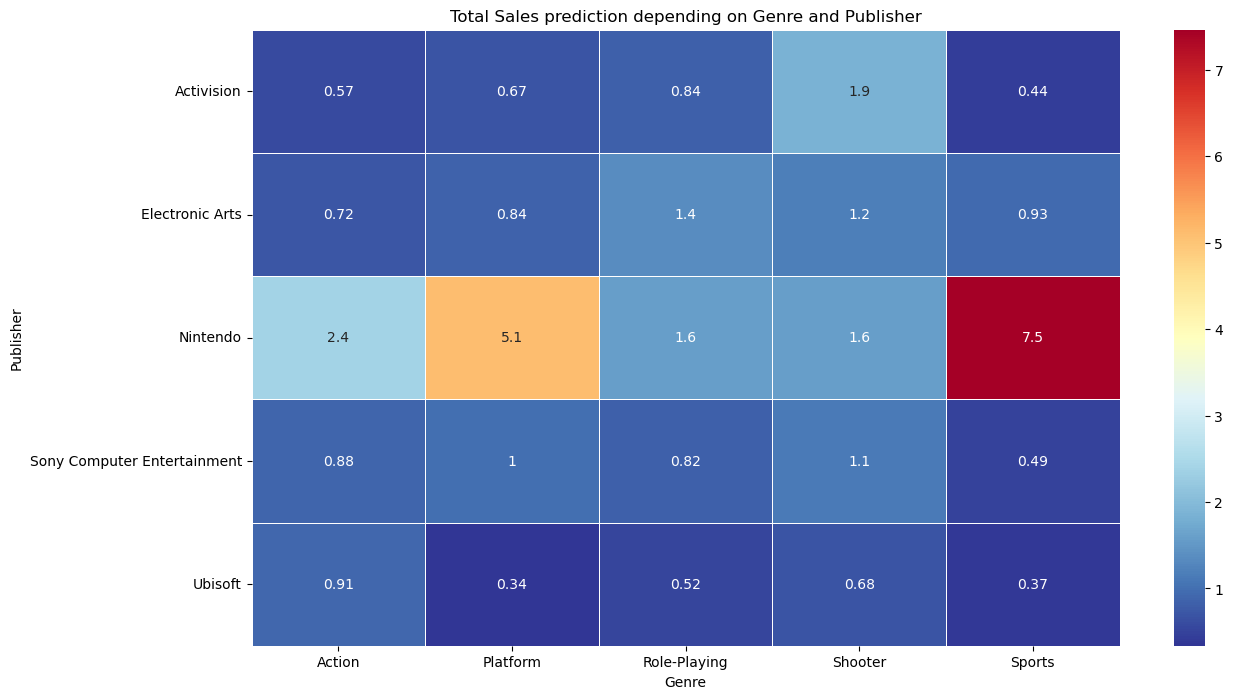

In [30]:
# Expected sales depending on Publisher and Genre
plt.figure(figsize=(14, 8))
pivot_table = combinations.pivot_table(index='Publisher', columns='Genre', values='Global_Sales')
sns.heatmap(pivot_table, cmap='RdYlBu_r', annot=True, linewidths=.5)
plt.title('Total Sales prediction depending on Genre and Publisher')
plt.xlabel('Genre')
plt.ylabel('Publisher')
plt.show()

We can see here the expected sales for Publisher and Genre combination. Games with most sales expected are Nintendo publisher with sport genre, that is expected to sell 7.5M games, followed by Nintendo Publisher and Platform genre, with 5.1M sales expected. As we can see on the previous step, Nintendo is the best publisher in terms of sales per game.

Let's now do the same analysis for the other combinations of features: 'Genre and Platform' ('Publisher and Platform' doesn't make sense, as each platform is released by one specific Publisher):

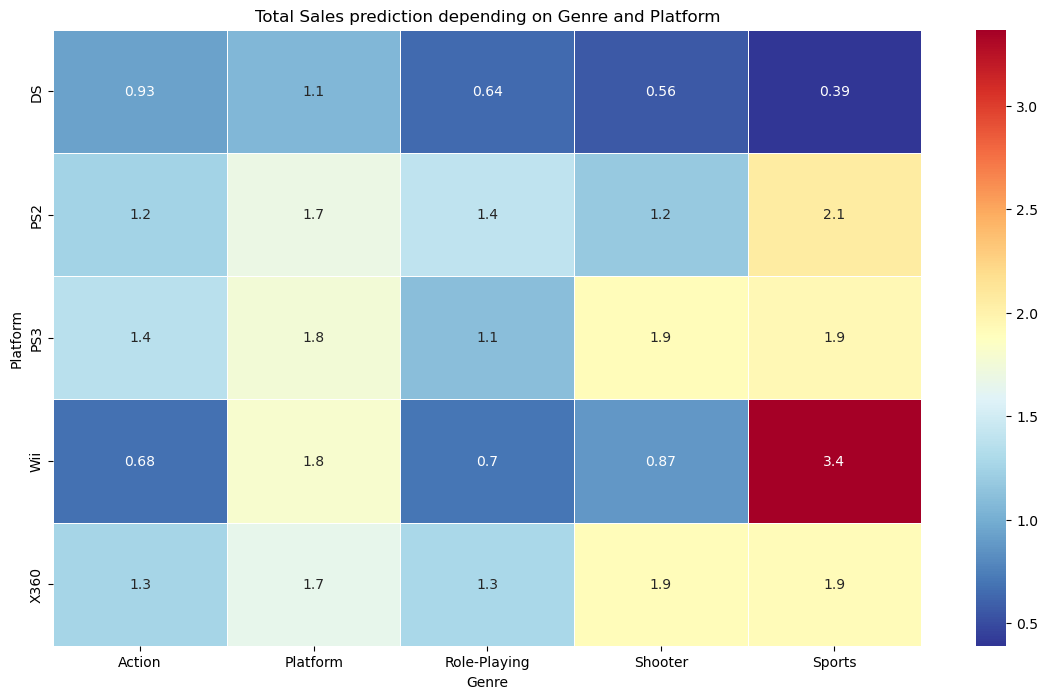

In [32]:
# Expected sales depending on Publisher and Genre
plt.figure(figsize=(14, 8))
pivot_table = combinations.pivot_table(index='Platform', columns='Genre', values='Global_Sales')
sns.heatmap(pivot_table, cmap='RdYlBu_r', annot=True, linewidths=.5)
plt.title('Total Sales prediction depending on Genre and Platform')
plt.xlabel('Genre')
plt.ylabel('Platform')
plt.show()

Here we can see a clear predomination in Platform Wii and genre Sports. Further investigations on this insight told us that there was a game called 'Wii Sports' that was given for free when soeone bought a wii console. If you want to know further about it, there is [more information on this link](https://en.wikipedia.org/wiki/Wii_(video_game_series)#:~:text=Wii%20Sports,-Game&text=The%20first%20game%20in%20the,simple%20graphics%2C%20and%20motion%20control.).

Another interesting insight is that, surprisingly, the Nintendo Platforms (DS and Wii) are forecasted to have good sales just in specific genres, but much worse income on the others. The difference is specially relevant.

And now, what could happen when forecasting for regions? In the following lines, and with the purpose of not making this study so long, we'll do the analysis for EU and JP region:

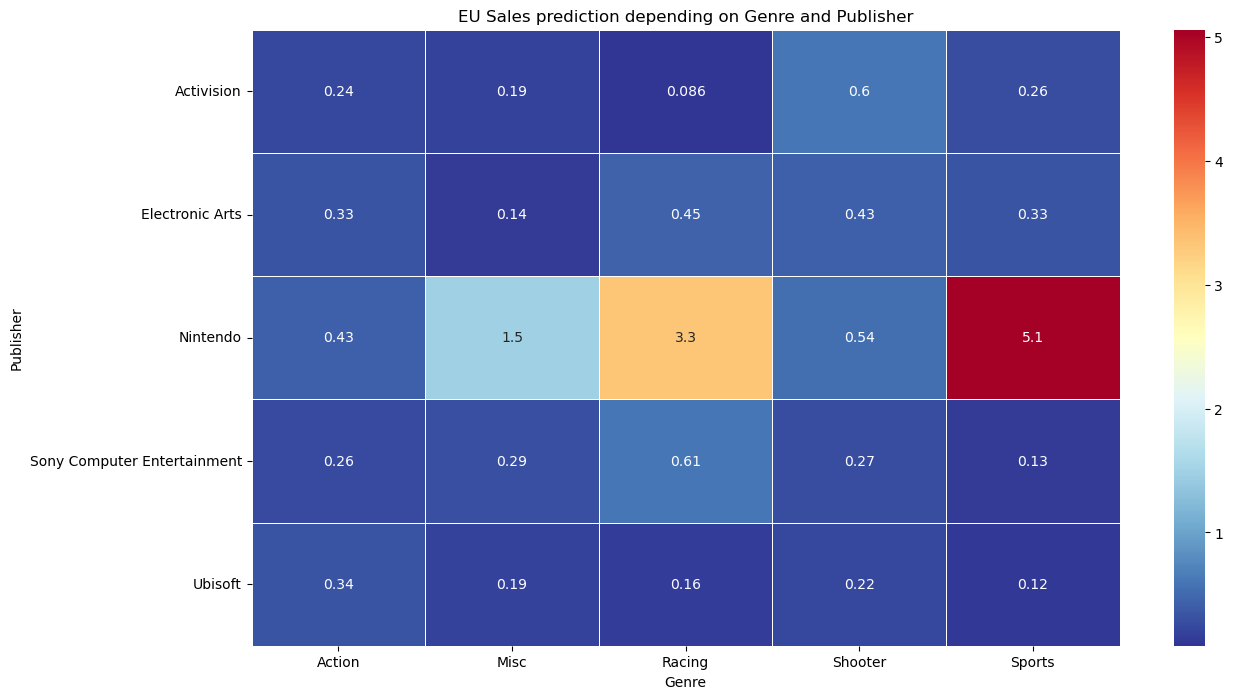

In [34]:
top_platforms = data.groupby('Platform')['EU_Sales'].sum().nlargest(5).index
top_genres = data.groupby('Genre')['EU_Sales'].sum().nlargest(5).index
top_publishers = data.groupby('Publisher')['EU_Sales'].sum().nlargest(5).index

filtered_data = data[data['Platform'].isin(top_platforms) & 
                     data['Genre'].isin(top_genres) &
                     data['Publisher'].isin(top_publishers)]


X = filtered_data[['Platform', 'Genre', 'Publisher']]
y = filtered_data[['EU_Sales']]


preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['Platform', 'Genre', 'Publisher'])
    ]
)


model = RandomForestRegressor(n_estimators=100, random_state=32)


pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', model)
])


pipeline.fit(X, y.values.ravel())


combinations = pd.MultiIndex.from_product([top_platforms, top_genres, top_publishers],
                                         names=['Platform', 'Genre', 'Publisher']).to_frame(index=False)


predictions = pipeline.predict(combinations)


combinations['EU_Sales'] = predictions


plt.figure(figsize=(14, 8))
pivot_table = combinations.pivot_table(index='Publisher', columns='Genre', values='EU_Sales')
sns.heatmap(pivot_table, cmap='RdYlBu_r', annot=True, linewidths=.5)
plt.title('EU Sales prediction depending on Genre and Publisher')
plt.xlabel('Genre')
plt.ylabel('Publisher')
plt.show()

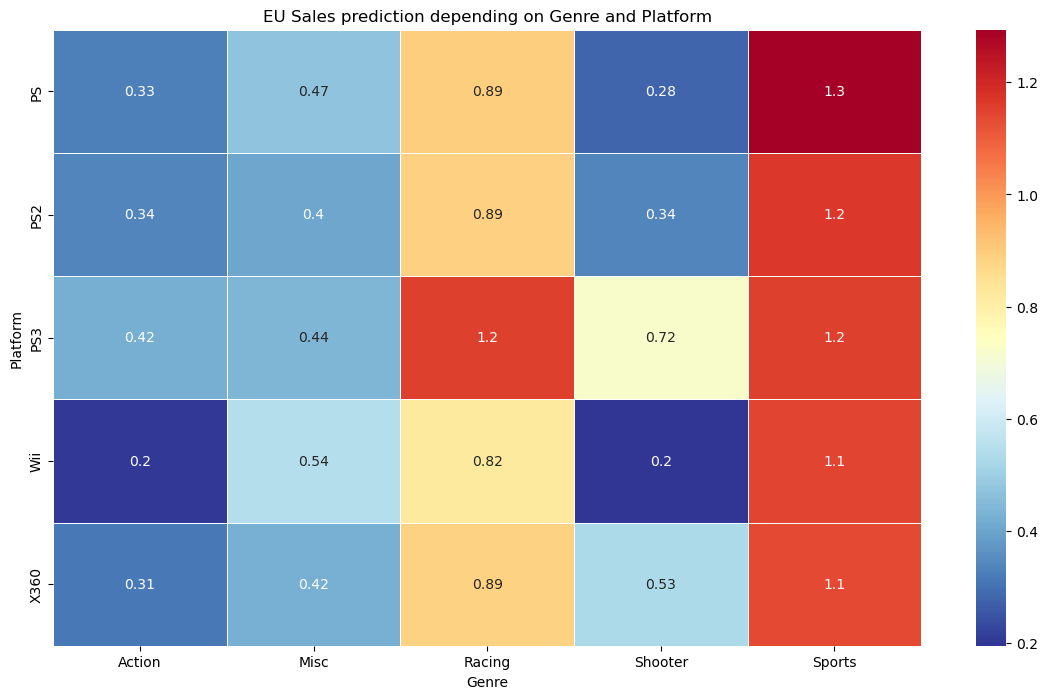

In [35]:
plt.figure(figsize=(14, 8))
pivot_table = combinations.pivot_table(index='Platform', columns='Genre', values='EU_Sales')
sns.heatmap(pivot_table, cmap='RdYlBu_r', annot=True, linewidths=.5)
plt.title('EU Sales prediction depending on Genre and Platform')
plt.xlabel('Genre')
plt.ylabel('Platform')
plt.show()

Surprisingly, in EU, the Sports Genre is the most relevant for sales. Let's see JP Sales:

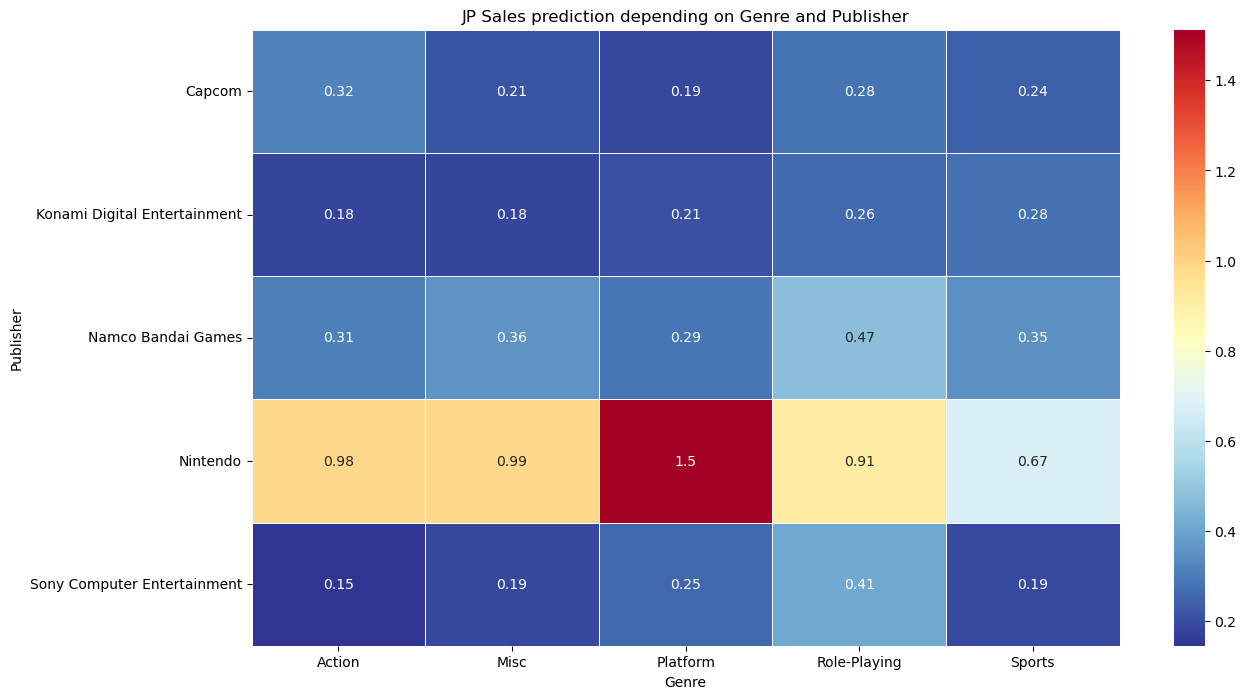

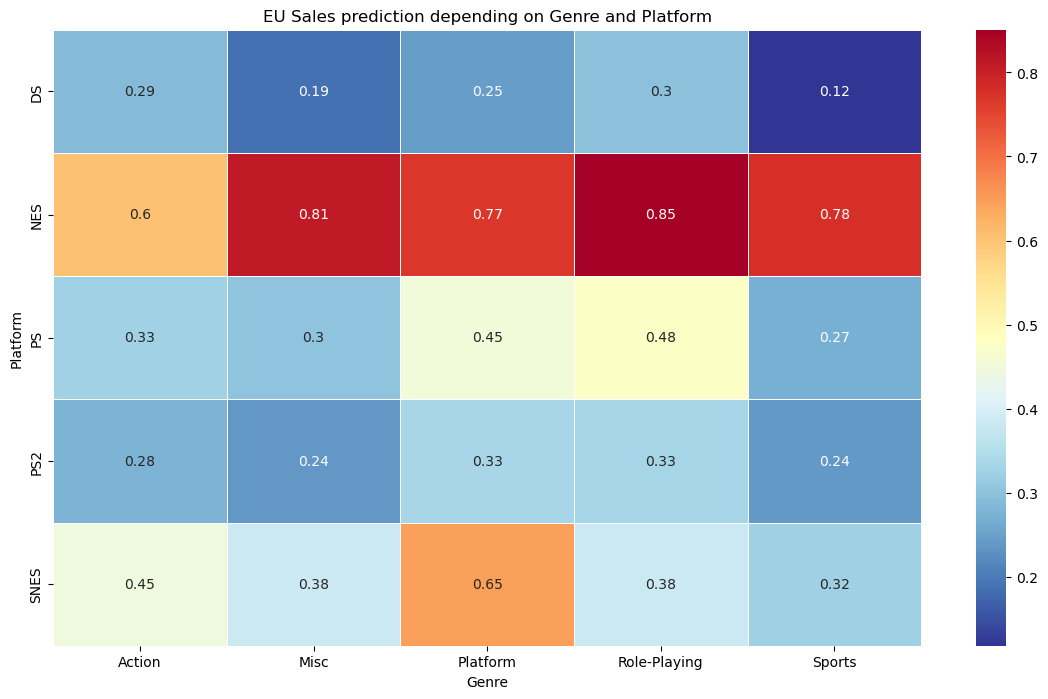

In [37]:
top_platforms = data.groupby('Platform')['JP_Sales'].sum().nlargest(5).index
top_genres = data.groupby('Genre')['JP_Sales'].sum().nlargest(5).index
top_publishers = data.groupby('Publisher')['JP_Sales'].sum().nlargest(5).index

filtered_data = data[data['Platform'].isin(top_platforms) & 
                     data['Genre'].isin(top_genres) &
                     data['Publisher'].isin(top_publishers)]


X = filtered_data[['Platform', 'Genre', 'Publisher']]
y = filtered_data[['JP_Sales']]


preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['Platform', 'Genre', 'Publisher'])
    ]
)


model = RandomForestRegressor(n_estimators=100, random_state=32)


pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', model)
])


pipeline.fit(X, y.values.ravel())


combinations = pd.MultiIndex.from_product([top_platforms, top_genres, top_publishers],
                                         names=['Platform', 'Genre', 'Publisher']).to_frame(index=False)


predictions = pipeline.predict(combinations)


combinations['JP_Sales'] = predictions


plt.figure(figsize=(14, 8))
pivot_table = combinations.pivot_table(index='Publisher', columns='Genre', values='JP_Sales')
sns.heatmap(pivot_table, cmap='RdYlBu_r', annot=True, linewidths=.5)
plt.title('JP Sales prediction depending on Genre and Publisher')
plt.xlabel('Genre')
plt.ylabel('Publisher')
plt.show()


plt.figure(figsize=(14, 8))
pivot_table = combinations.pivot_table(index='Platform', columns='Genre', values='JP_Sales')
sns.heatmap(pivot_table, cmap='RdYlBu_r', annot=True, linewidths=.5)
plt.title('EU Sales prediction depending on Genre and Platform')
plt.xlabel('Genre')
plt.ylabel('Platform')
plt.show()

NES is the most important platform when forecasting sales in Japan.

Now that we've seen the forecasting for different combinations. What about theevolution of global sales? Let's see how the videogames sales are expected to develop over time; first, for global sales, and then, for different regions:

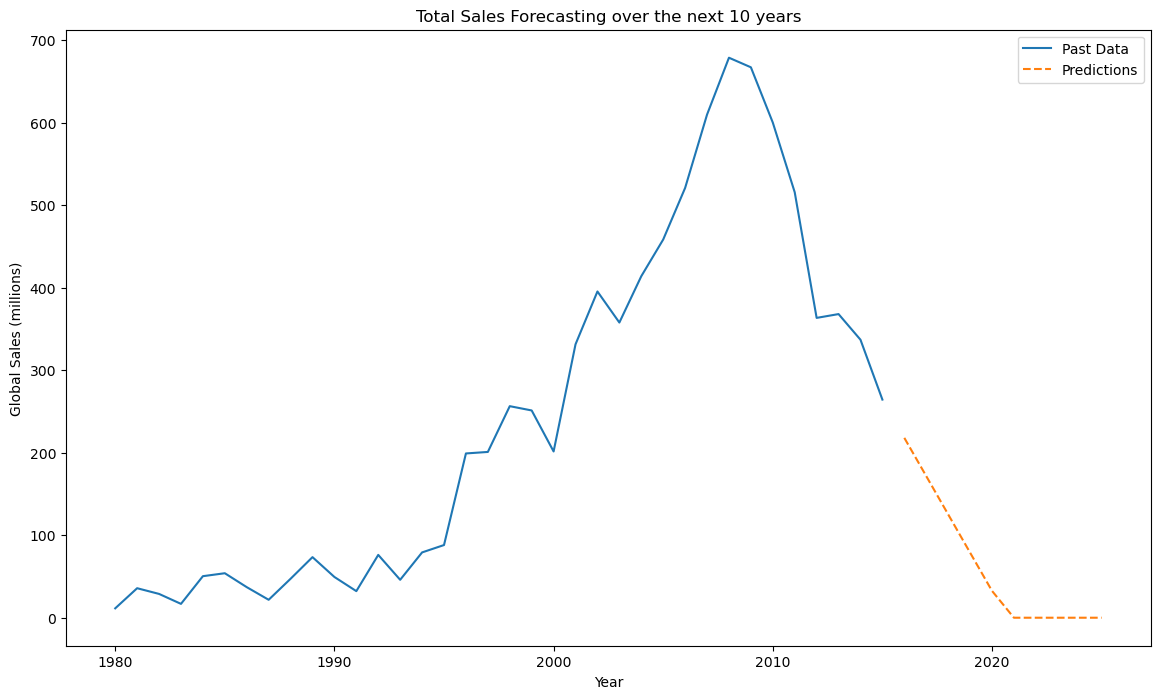

In [39]:
annual_sales = data.groupby('Year')['Global_Sales'].sum().reset_index()

model = ExponentialSmoothing(annual_sales['Global_Sales'], trend='add', seasonal=None, seasonal_periods=None)
model_fit = model.fit()

# Predicting the next 10 years
future_years = np.arange(2016, 2026)
future_forecast = model_fit.forecast(len(future_years))

# Create a Data Frame for future predictions
future_sales = pd.DataFrame({'Year': future_years, 'Global_Sales': future_forecast})
future_sales = np.maximum(future_sales, 0)


plt.figure(figsize=(14, 8))
sns.lineplot(x='Year', y='Global_Sales', data=annual_sales, label='Past Data')
sns.lineplot(x='Year', y='Global_Sales', data=future_sales, label='Predictions', linestyle='--')
plt.title('Total Sales Forecasting over the next 10 years')
plt.xlabel('Year')
plt.ylabel('Global Sales (millions)')
plt.legend()
plt.show()

We can see here how the forecasting was to keep decreasing in sales until it gets to zero. Let's see the same analysis for each region:

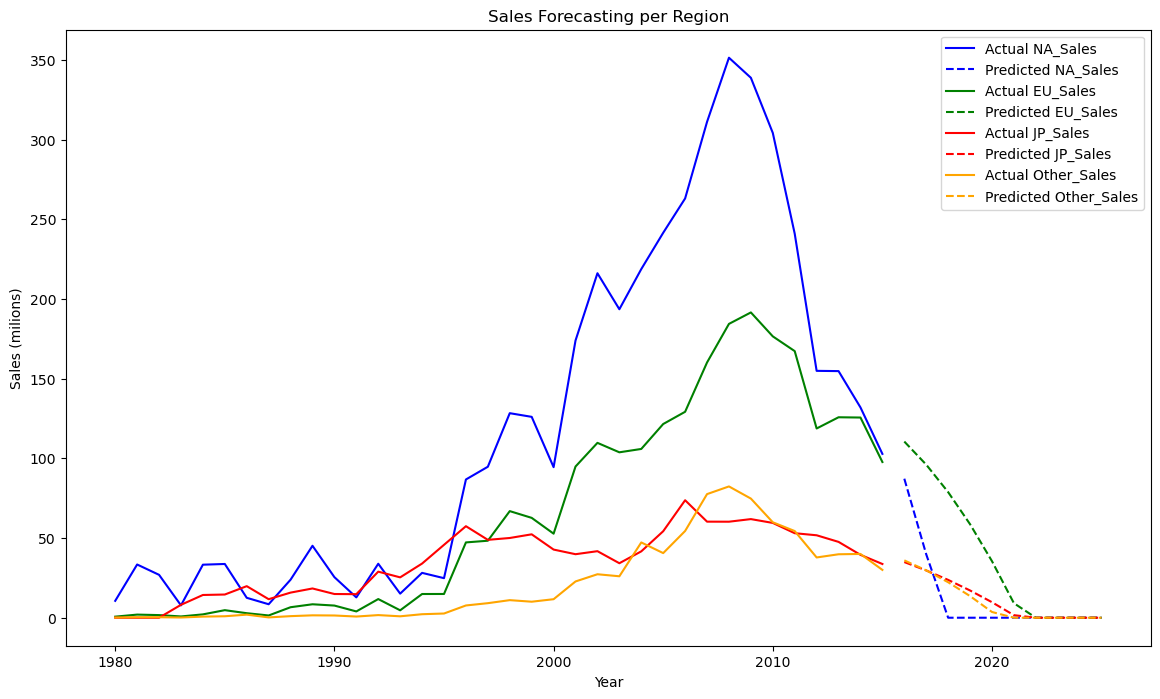

In [41]:
annual_sales = data.groupby('Year')[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']].sum().reset_index()


X = annual_sales['Year'].values.reshape(-1, 1)
y = annual_sales[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']].values


poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(X)
model = LinearRegression()
model.fit(X_poly, y)


future_years = np.arange(2016, 2026).reshape(-1, 1)
future_years_poly = poly.transform(future_years)
future_sales = model.predict(future_years_poly)


future_sales = np.maximum(future_sales, 0)


future_data = pd.DataFrame({
    'Year': future_years.flatten(),
    'NA_Sales': future_sales[:, 0],
    'EU_Sales': future_sales[:, 1],
    'JP_Sales': future_sales[:, 2],
    'Other_Sales': future_sales[:, 3]
})


colors = {
    'NA_Sales': 'blue',
    'EU_Sales': 'green',
    'JP_Sales': 'red',
    'Other_Sales': 'orange'
}


plt.figure(figsize=(14, 8))
for region in ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']:
    plt.plot(annual_sales['Year'], annual_sales[region], label=f'Actual {region}', color=colors[region])
    plt.plot(future_data['Year'], future_data[region], linestyle='--', color=colors[region], label=f'Predicted {region}')
plt.title('Sales Forecasting per Region')
plt.xlabel('Year')
plt.ylabel('Sales (milions)')
plt.legend()
plt.show()

Even there is difference in the evolution of sales, al the regions are predicted to have a decrease on sales on the next years.